In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
from scipy.stats import chi2_contingency
import pickle

Data analysis for TB3 and TB4

Text(0.5, 1.0, 'Cigarettes usually smoke in a day')

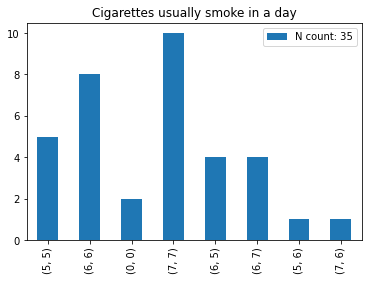

In [161]:
TB_w1 = [5,6,0,6,6,5,7,5,7,6,6,6,7,0,5,6,7,7,6,6,7,6,6,7,6,5,6,7,6,5,7,7,7,6,6]
TB_w2 = [5,6,0,6,6,5,7,5,7,6,5,7,7,0,6,6,7,7,7,5,7,5,5,7,6,5,6,7,6,5,7,7,6,7,7]

comb_counts = Counter(list(zip(TB_w1, TB_w2)))
df = pd.DataFrame.from_dict(comb_counts, orient='index')
fig, ax = plt.subplots()
df.plot(kind='bar',ax=ax)
ax.legend([f'N count: {len(TB_w1)}'])
ax.set_title('Cigarettes usually smoke in a day')

'\nLower triangle --> decrease in use\nUpper triangle --> increase in use\n'

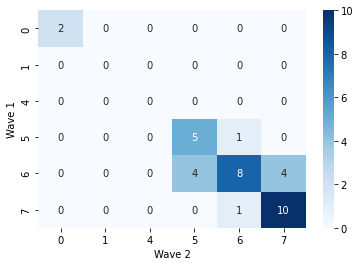

In [162]:
TB_combs = list(zip(TB_w1, TB_w2))
categories = [0,1,4,5,6,7]
x, y = np.meshgrid(categories,categories)
intensity = np.zeros((len(categories),len(categories)))
for i in range(intensity.shape[0]):
    for j in range(intensity.shape[1]):
        intensity[i,j] = TB_combs.count((categories[i],categories[j]))

s = sns.heatmap(intensity, annot=True, cmap='Blues', xticklabels=categories, yticklabels=categories)
s.set(xlabel='Wave 2', ylabel='Wave 1')
'''
Lower triangle --> decrease in use
Upper triangle --> increase in use
'''

### Impute

#### TB

- If TB2 = 5, then, TB2_4_TEXT = -1, TB3 = 1, TB4 = 0 (never smoked a cig)
- If TB3 = 1, then TB4 = 0
- If TB5 = 1, then TB6 = -1, TB7 = 1, TB8 = 0 (never used e-cig)
- If TB7 = 1, then TB8 = 0
- If TB9 = 1, then TB10 = -1, TB11 = 1, TB12 = 0 (never used smokeless tobacco)
- If TB11 = 1, then TB12 = 0

Combine TB2 and TB2_4_TEXT into one (take TB2 only)

#### AL

- If AL1 = 2, then AL1_4_TEXT = -1, AL2_1_TEXT = -1, AL3_1_TEXT = -1, AL4 = 1, AL5 = 0, AL6A = 0, AL6B = 0 (did not drink at all)
    - If AL1 = 3, then AL1_4_TEXT = -2
- If AL2 = 2 and/or AL3 = 2, then AL2_1_TEXT = -2 and/or AL3_1_TEXT = -2
- If AL5 = 1, then AL6A = 0, AL6B = 0 (did not drink in past 30 days)

Combine AL1 and AL1_4_TEXT, AL2 and AL2_1_TEXT, AL3 and AL3_1_TEXT, AL6A and AL6B (take AL1, AL2, AL3, AL6A only)

#### ID and ND

- If ID1 = 1, then ID2 = -1, ID3-12 = 0, ID15-20 = -1
- If ID3 = 1, then ID4-12 = 0, ID15-20 = -1 (wrong labels in C1W1, changed it back in terms of .docx labels beforehand)
- If ID17 = 1, then ID18-20 = -1
- If ND1 = 1, then ND2 = -1

In [3]:
def impute_MARs(vars, df):

    for v in vars:
        col = df[v]
        if v == 'TB2':
            for idx, i in enumerate(col):
                if i == 5:
                    df.at[idx, 'TB2_4_TEXT'] = -1
                    df.at[idx, 'TB3'] = 1
                    df.at[idx, 'TB4'] = 0
        if v == 'TB3':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'TB4'] = 0
        if v == 'TB5':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'TB6'] = -1
                    df.at[idx, 'TB7'] = 1
                    df.at[idx, 'TB8'] = 0
        if v == 'TB7':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'TB8'] = 0
        if v == 'TB9':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'TB10'] = -1
                    df.at[idx, 'TB11'] = 1
                    df.at[idx, 'TB12'] = 0
        if v == 'TB11':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'TB12'] = 0
        if v == 'AL1':
            for idx, i in enumerate(col):
                if i == 2:
                    df.at[idx, 'AL1_4_TEXT'] = -1
                    df.at[idx, 'AL2_1_TEXT'] = -1
                    df.at[idx, 'AL3_1_TEXT'] = -1
                    df.at[idx, 'AL4'] = 1
                    df.at[idx, 'AL5'] = 0
                    df.at[idx, 'AL6A'] = 0
                    df.at[idx, 'AL6B'] = 0
                elif i == 3:
                    df.at[idx, 'AL1_4_TEXT'] = -2
        if v == 'AL2':
            for idx, i in enumerate(col):
                if i == 2:
                    df.at[idx, 'AL2_1_TEXT'] = -2
        if v == 'AL3':
            for idx, i in enumerate(col):
                if i == 2:
                    df.at[idx, 'AL3_1_TEXT'] = -2
        if v == 'AL5':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'AL6A'] = 0
                    df.at[idx, 'AL6B'] = 0
        if v == 'AL6A':
            for idx, i in enumerate(col):
                if pd.isnull(df.loc[idx, v]) and not pd.isnull(df.loc[idx, 'AL6B']):
                    df.at[idx, v] = df.at[idx, 'AL6B']
        if v == 'ID1':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'ID2'] = -1
                    for j in range(3,13):
                        df.at[idx, f'ID{j}'] = 0
                    for j in range(15,21):
                        df.at[idx, f'ID{j}'] = -1
        if v == 'ID3':
            for idx, i in enumerate(col):
                if i == 1:
                    for j in range(4,13):
                        df.at[idx, f'ID{j}'] = 0
                    for j in range(15,21):
                        df.at[idx, f'ID{j}'] = -1
        if v == 'ID17':
            for idx, i in enumerate(col):
                if i == 1:
                    for j in range(18,21):
                        df.at[idx, f'ID{j}'] = -1
        if v == 'ND1':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'ND2'] = -1
        if v == 'OD1':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'OD2'] = 0
        if v == 'OD6':
            for idx, i in enumerate(col):
                if i == 2:
                    for j in range(7,12):
                        df.at[idx, f'OD{j}'] = 0
        if v == 'OD8':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'OD9'] = 0
        if v == 'OD10':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'OD11'] = 0
        if v == 'CJ3':
            for idx, i in enumerate(col):
                if i == 1:
                    for j in range(4,8):
                        df.at[idx, f'CJ{j}'] = -1
        if v == 'DM12':
            for idx, i in enumerate(col):
                if i != 1:
                    df.at[idx, 'DM13'] = -1

    vars_mixed = ['DM1','TB2_4_TEXT','TB6','TB10','AL1_4_TEXT','AL2_1_TEXT','AL3_1_TEXT','ID2','ND2']
    for v in vars_mixed:
        col = df[v]
        if v[-4:] == 'TEXT':  # e.g., modify TB2 column instead of TB2_4_TEXT
            v = v.split('_')[0]
        for idx, i in enumerate(col):
            if 0 <= i <= 14:    df.at[idx, v] = 0  # children
            elif 15 <= i <= 24: df.at[idx, v] = 1  # youth
            elif 25 <= i <= 64: df.at[idx, v] = 2  # adult
            elif i >= 65:       df.at[idx, v] = 3  # senior
            elif i == -1:       df.at[idx, v] = -1  # never
            elif i == -2 or (np.isnan(i) and df.at[idx, v] == 4):       df.at[idx, v] = np.nan  # don't know

    v = 'SC1'  # numerical variable (# of years)
    col = df[v]
    for idx, i in enumerate(col):
        if i < 0.5:    df.at[idx, v] = 0  # less than 6 months
        elif 0.5 <= i < 1:  df.at[idx, v] = 1  # 
        elif 1 <= i < 2:    df.at[idx, v] = 2  #
        elif 2 <= i < 5:    df.at[idx, v] = 3  #
        elif 5 <= i < 10:    df.at[idx, v] = 4  #
        elif i >= 10:       df.at[idx, v] = 5  # more than 10 years

    return df

In [10]:
datapath = 'data/original/pre-imputed/'
C1W1nonet_df = pd.read_csv(datapath + 'C1W1_nonnetwork_preimputed.csv')
C1W2nonet_df = pd.read_csv(datapath + 'C1W2_nonnetwork_preimputed.csv')
mappings_df = pd.read_csv(datapath + 'mappings.csv')

C1W1nonet_vars = list(C1W1nonet_df.columns)
C1W2nonet_vars = list(C1W2nonet_df.columns)

In [165]:
def clean_C1W2(vars, df):
    '''
    shift the labels of C1W2 wrt C1W1
    Note: ensure correct data format in C1W2 beforehand (e.g., no strings in numerical vars, no -88,-77, etc.)
    '''
    for v in vars:
        col = df[v]
        if v == 'Q22':             # TB4
            for idx, i in enumerate(col):
                if i in range(1,5):
                    df.at[idx, v] = i+3
                elif i == 0:
                    df.at[idx, v] = 1
        if v == 'Q26' or v == 'Q30' or v in [f'Q{j}' for j in range(71,81)]:       # TB8, TB12, ND3-12
            for idx, i in enumerate(col):
                if i in range(10):
                    df.at[idx, v] = i+1
        if v == 'Q35' or v == 'Q68':          # AL5, ND1
            for idx, i in enumerate(col):
                if i in range(1,8):
                    df.at[idx, v] = i+8
                elif i == 0:
                    df.at[idx, v] = 1
        if v in [f'Q4{j}' for j in range(1,10)]:    # ID4-12
            for idx, i in enumerate(col):
                if i in range(1,8):
                    df.at[idx, v] = i+10
                elif i == 0:
                    df.at[idx, v] = 1

    return df

In [29]:
mappings = []
with open('data/original/pre-imputed/mappings.csv', 'r') as f:          # Read lines separately
    reader = csv.reader(f, delimiter=',')
    for i, line in enumerate(reader):
        mappings.append(line)

In [167]:
df_w1 = impute_MARs(C1W1nonet_vars, C1W1nonet_df)
vars_w1 = ['TB4','TB8','TB12','AL5'] + [f'ID{i}' for i in range(4,13)] + [f'ND{i}' for i in range(1,13) if i !=2]
df_w1 = df_w1[vars_w1]
vars_w2 = []
for var in vars_w1:  # map with C1W2
    vars_w2.append(mappings_df.at[0,var])

df_w2 = C1W2nonet_df[vars_w2]
df_w2 = clean_C1W2(vars_w2, df_w2)

for i, var in enumerate(vars_w1):
    df_w1.insert(df_w1.columns.get_loc(var)+1, vars_w2[i], list(df_w2[vars_w2[i]]))

df_w1.to_csv(datapath + 'C1_nonnetwork_pred.csv', index=False)

'''
impute MAR for C1W2 manually afterwards
'''

### Analysis for all drugs (in Cohort 1)

In [33]:
labelings = ['Cigarettes usually smoke in a day',
            'Days vaped or used e-cigarettes with nicotine in the past 30 days',
            'Days used smokeless tobacco in the past 30 days',
            'How often drank alcohol in the past 30 days',
            'How often injected heroin in the past 6 months',
            'How often injected prescription opioids in the past 6 months',
            'How often injected methamphetamine in the past 6 months',
            'How often injected cocaine in the past 6 months',
            'How often injected heroin and cocaine speedball in the past 6 months',
            'How often injected heroin and methamphetamine speedball in the past 6 months',
            'How often injected crack cocaine in the past 6 months',
            'How often injected buprenorphine in the past 6 months',
            'How often injected sth else in the past 6 months',
            'How often used marijuana in the past 6 months',
            'How often used cocaine in the past 6 months',
            'How often used Ecstasy/MDMA in the past 6 months',
            'How often used PCP/angel dust in the past 6 months',
            'How often used amphetamines in the past 6 months',
            'How often used methamphetamine in the past 6 months',
            'How often used barbiturates in the past 6 months',
            'How often used benzodiazepines in the past 6 months',
            'How often used opiates/opioids in the past 6 months',
            'How often used heroin in the past 6 months',
            'How often used sth else in the past 6 months'
]

In [ ]:
datapath = 'data/original/pre-imputed/'
df = pd.read_csv(datapath + 'C1_nonnetwork_pred.csv')
n_cols = len(list(df.columns))

for i in np.arange(0,n_cols,2):

    w1_var, w2_var = df.columns[i], df.columns[i+1]
    drug_w1 = list(df.iloc[:,i])
    drug_w2 = list(df.iloc[:,i+1])

    drug_w1_nonan, drug_w2_nonan = [], []  # do not consider coupling if either one is nan
    for a, b in zip(drug_w1, drug_w2):
        if not np.isnan(a) and not np.isnan(b):
            drug_w1_nonan.append(int(a))
            drug_w2_nonan.append(int(b))

    fig, axs = plt.subplots(1, 2, tight_layout=False, figsize=(10,5))
    plt.suptitle(labelings[int(np.floor((i+1)/2))])

    # histogram
    comb_counts = Counter(list(zip(drug_w1_nonan, drug_w2_nonan)))
    df_hist = pd.DataFrame.from_dict(comb_counts, orient='index')
    df_hist.plot(kind='bar',ax=axs[0])
    axs[0].legend([f'N count: {len(drug_w1_nonan)}'])

    # heatmap
    combs = list(zip(drug_w1_nonan, drug_w2_nonan))
    categories = list(set(drug_w1_nonan + drug_w2_nonan))
    x, y = np.meshgrid(categories,categories)
    intensity = np.zeros((len(categories),len(categories)))
    for i in range(intensity.shape[0]):
        for j in range(intensity.shape[1]):
            intensity[i,j] = combs.count((categories[i],categories[j]))

    s = sns.heatmap(intensity, annot=True, cmap='Blues', xticklabels=categories, yticklabels=categories, ax=axs[1])
    s.set(xlabel='Wave 2', ylabel='Wave 1')

    plt.savefig(f'plots/analysis/C1_{w1_var}-{w2_var}_plots.png', facecolor='white')

### Same for Cohort 2 (impute + analysis)

In [78]:
datapath = 'data/original/pre-imputed/'
C2W1nonet_df = pd.read_csv(datapath + 'C2W1_nonnetwork_preimputed.csv')
C2W2nonet_df = pd.read_csv(datapath + 'C2W2_nonnetwork_preimputed.csv')

C2W1nonet_vars = list(C2W1nonet_df.columns)
C2W2nonet_vars = list(C2W2nonet_df.columns)

mappings_df = pd.read_csv(datapath + 'mappings.csv')
mappings = []
with open('data/original/pre-imputed/mappings.csv', 'r') as f:          # Read lines separately
    reader = csv.reader(f, delimiter=',')
    for i, line in enumerate(reader):
        mappings.append(line)

In [79]:
df_w1 = impute_MARs(C2W1nonet_vars, C2W1nonet_df)
df_w2 = impute_MARs(C2W2nonet_vars, C2W2nonet_df)
vars = ['TB4','TB8','TB12','AL5'] + [f'ID{i}' for i in range(4,13)] + [f'ND{i}' for i in range(1,13) if i !=2]
df_w1 = df_w1[vars]
df_w2 = df_w2[vars]

for i, var in enumerate(vars):
    df_w1.insert(df_w1.columns.get_loc(var)+1, f'W2_{vars[i]}', list(df_w2[vars[i]]))

df_w1.to_csv(datapath + 'C2_nonnetwork_pred.csv', index=False)

Plot

/tmp/ipykernel_1790/1751988531.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, tight_layout=False, figsize=(15,5))


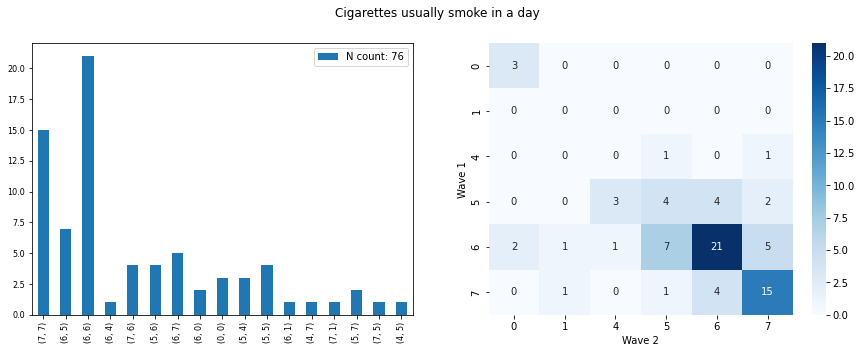

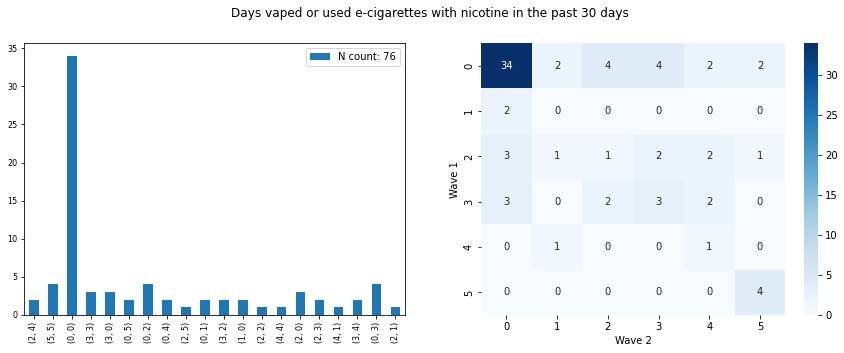

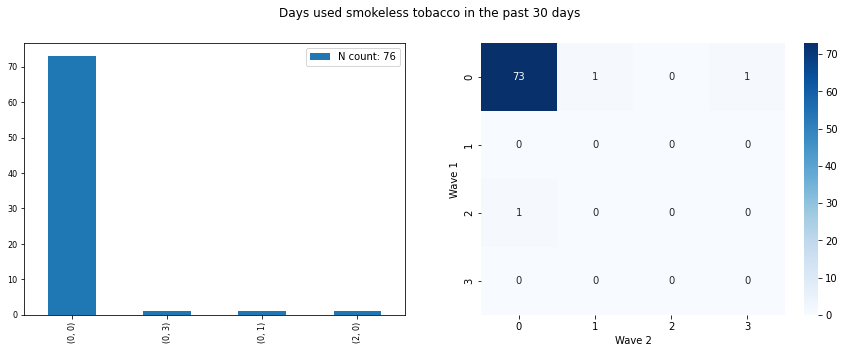

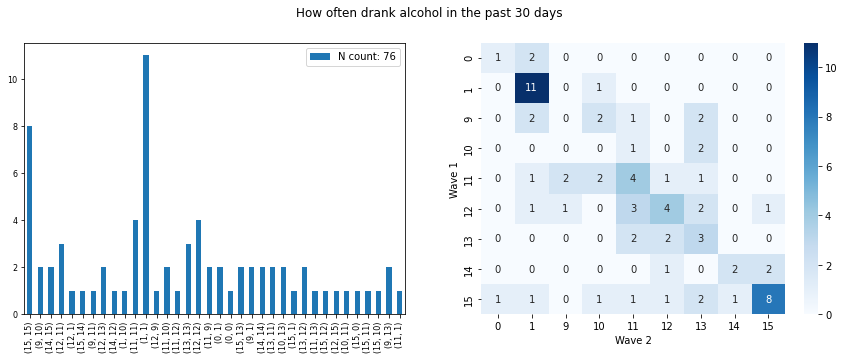

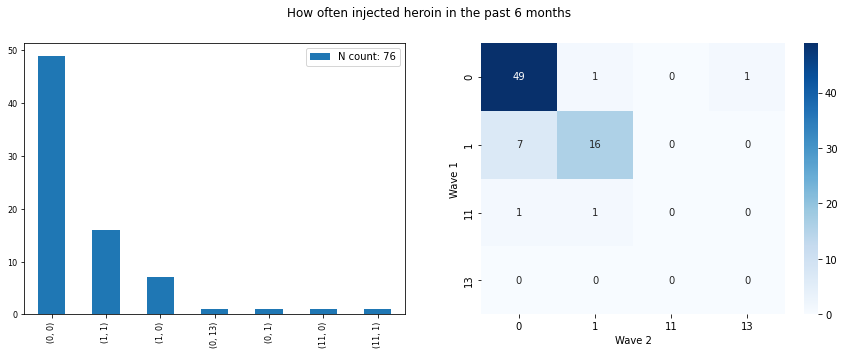

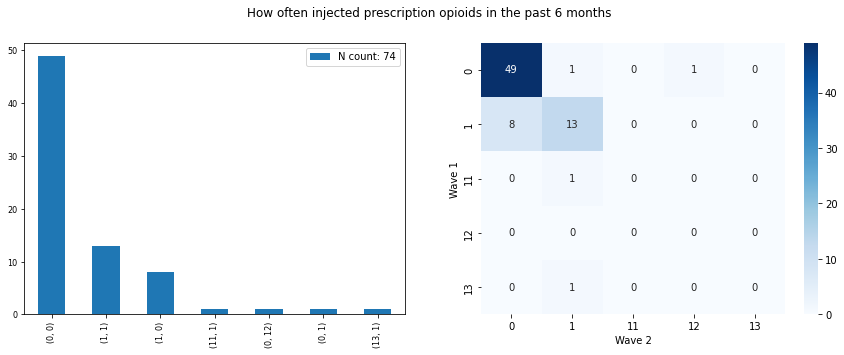

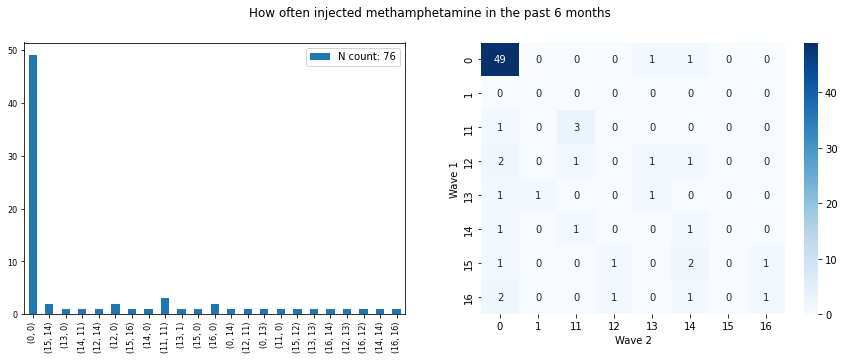

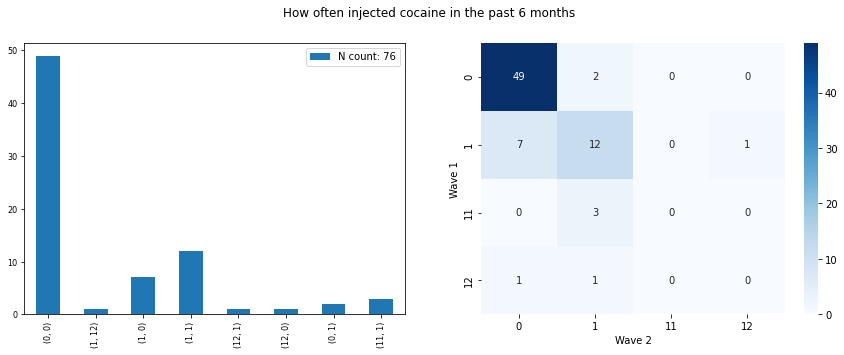

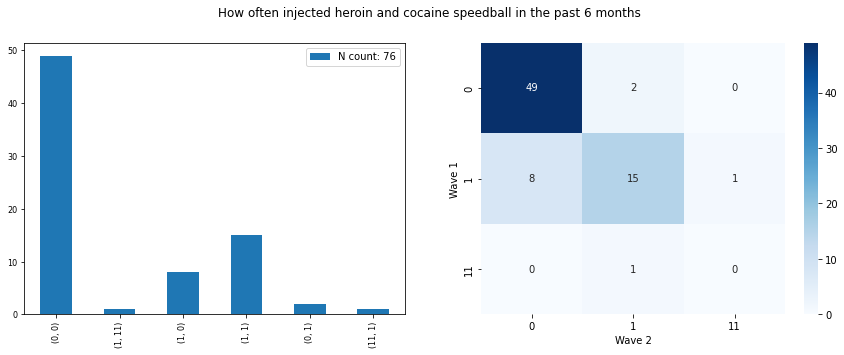

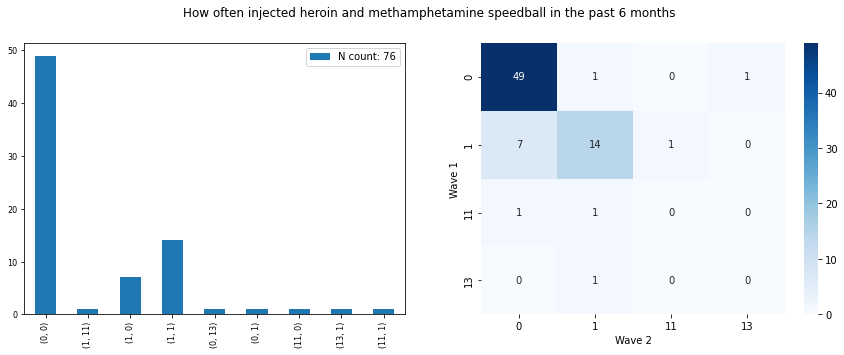

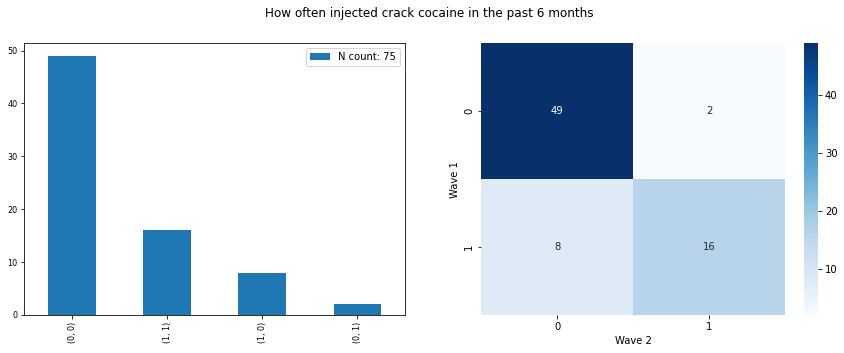

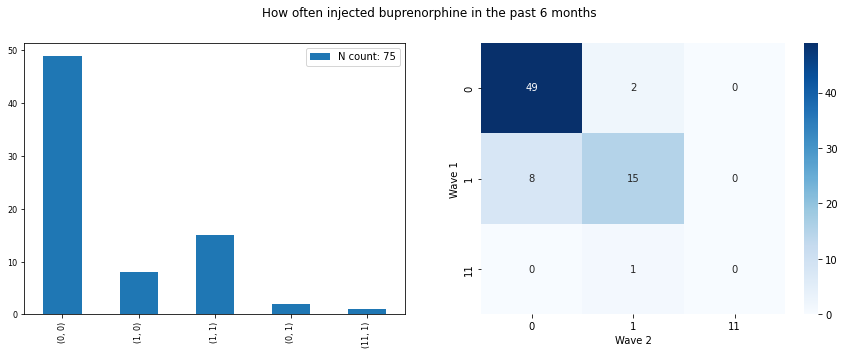

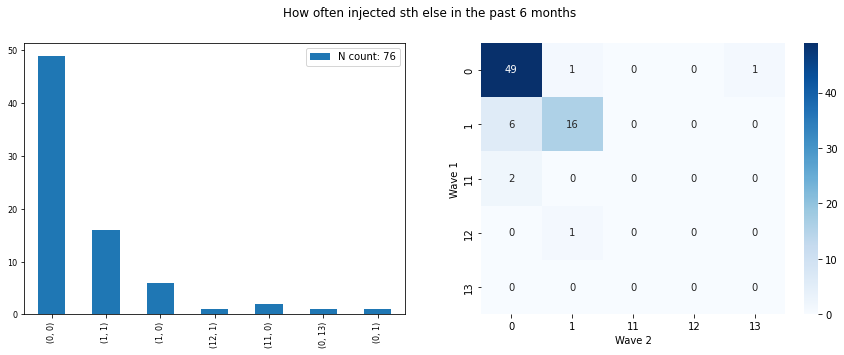

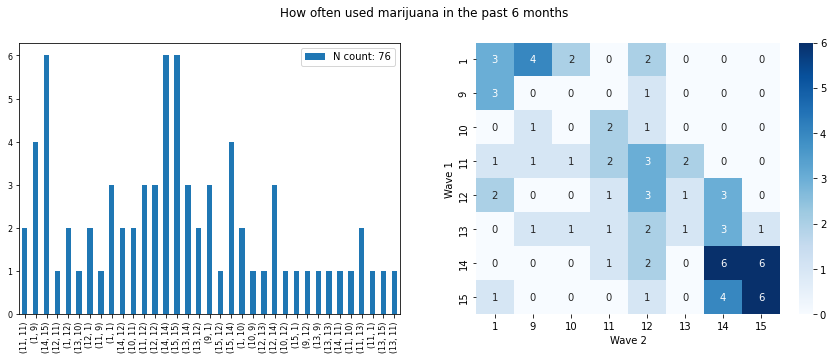

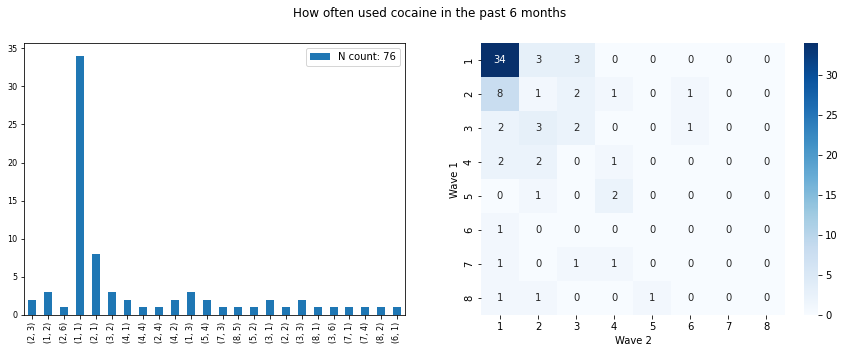

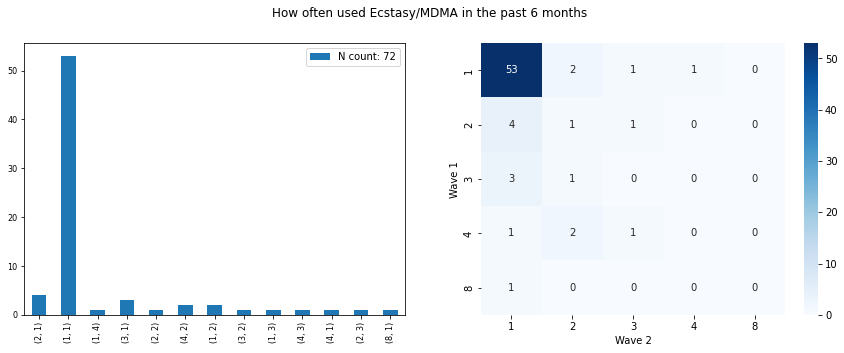

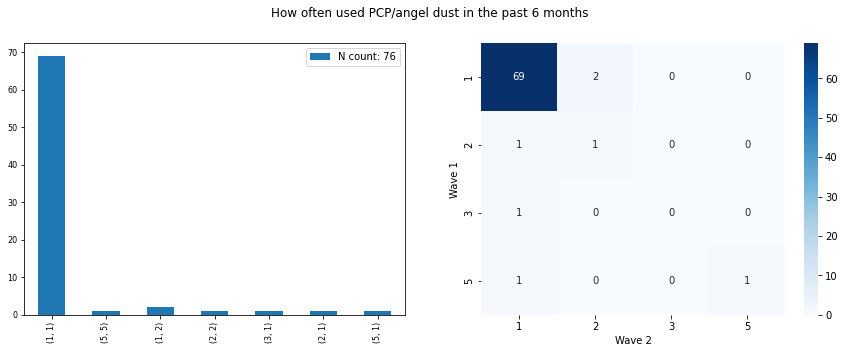

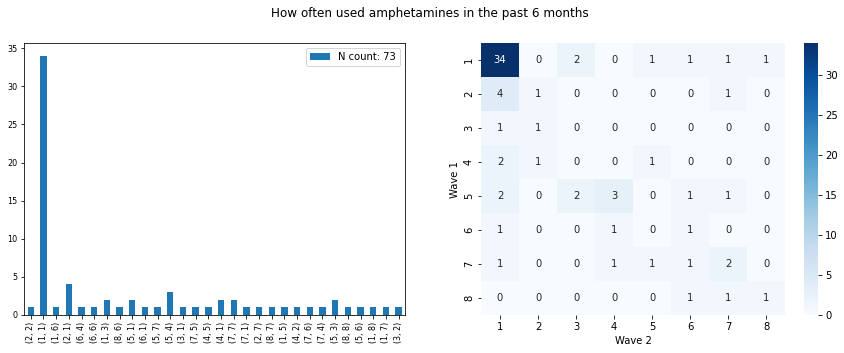

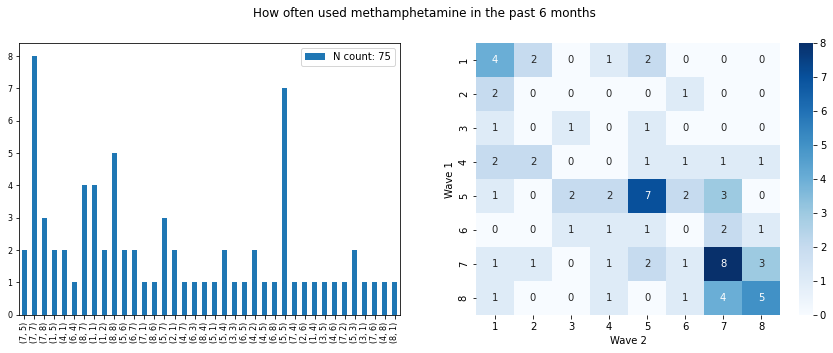

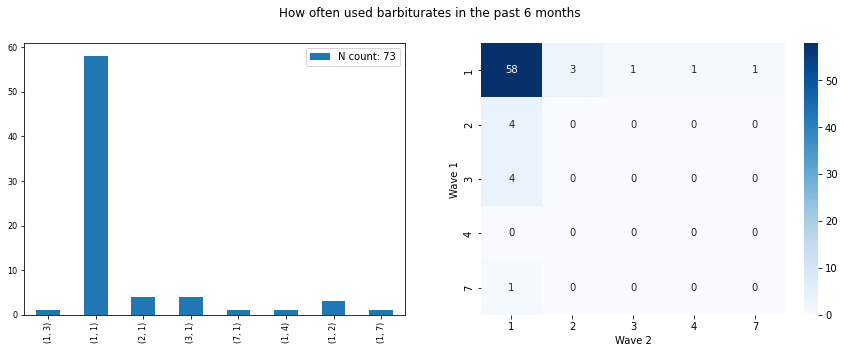

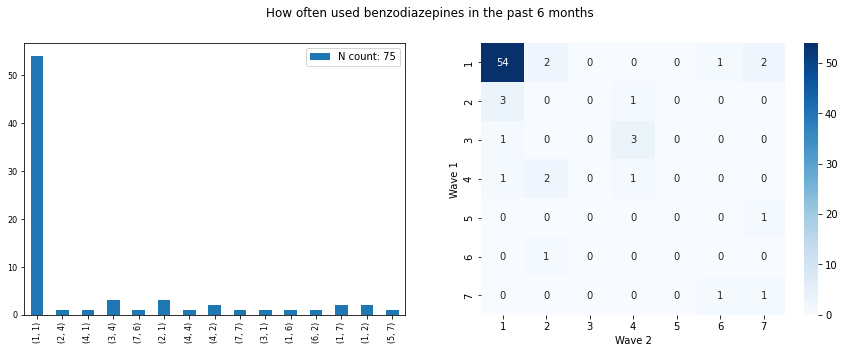

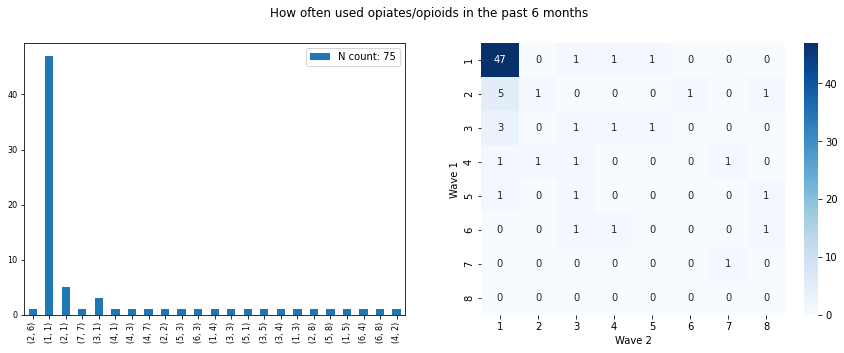

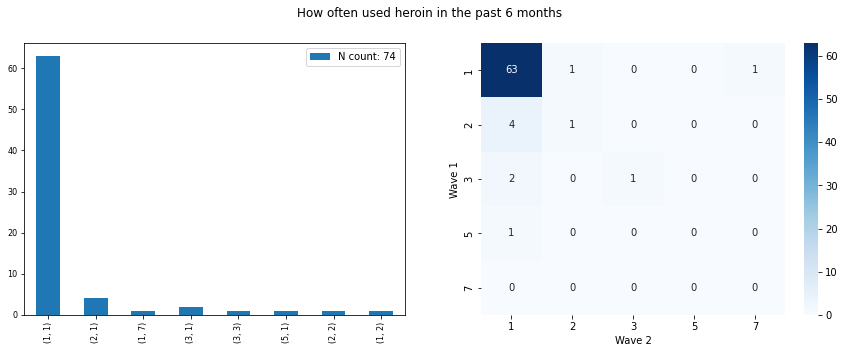

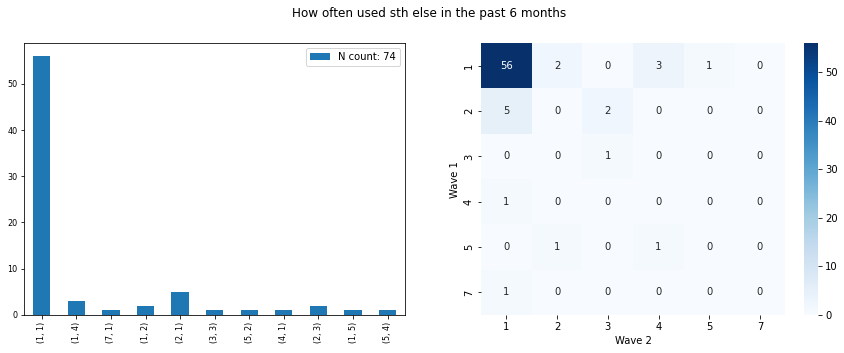

In [84]:
datapath = 'data/original/pre-imputed/'
df = pd.read_csv(datapath + 'C2_nonnetwork_pred.csv')
n_cols = len(list(df.columns))

for i in np.arange(0,n_cols,2):

    w1_var, w2_var = df.columns[i], df.columns[i+1]
    drug_w1 = list(df.iloc[:,i])
    drug_w2 = list(df.iloc[:,i+1])

    drug_w1_nonan, drug_w2_nonan = [], []  # do not consider coupling if either one is nan
    for a, b in zip(drug_w1, drug_w2):
        if not np.isnan(a) and not np.isnan(b):
            drug_w1_nonan.append(int(a))
            drug_w2_nonan.append(int(b))

    fig, axs = plt.subplots(1, 2, tight_layout=False, figsize=(15,5))
    plt.suptitle(labelings[int(np.floor((i+1)/2))])

    # histogram
    comb_counts = Counter(list(zip(drug_w1_nonan, drug_w2_nonan)))
    df_hist = pd.DataFrame.from_dict(comb_counts, orient='index')
    df_hist.plot(kind='bar',ax=axs[0],fontsize=8)
    axs[0].legend([f'N count: {len(drug_w1_nonan)}'])

    # heatmap
    combs = list(zip(drug_w1_nonan, drug_w2_nonan))
    categories = list(set(drug_w1_nonan + drug_w2_nonan))
    x, y = np.meshgrid(categories,categories)
    intensity = np.zeros((len(categories),len(categories)))
    for i in range(intensity.shape[0]):
        for j in range(intensity.shape[1]):
            intensity[i,j] = combs.count((categories[i],categories[j]))

    s = sns.heatmap(intensity, annot=True, cmap='Blues', xticklabels=categories, yticklabels=categories, ax=axs[1])
    s.set(xlabel='Wave 2', ylabel='Wave 1')

    plt.savefig(f'plots/analysis/C2_{w1_var}_plots.png', facecolor='white')

### Correlation between variables

Simple correlation analysis between different variables (only one of them) and the usage of marijuana/meth across 2 waves

In [10]:
datapath = 'data/original/pre-imputed/'
C1W1nonet_df = pd.read_csv(datapath + 'C1W1_nonnetwork_preimputed.csv')
C1pred_df = pd.read_csv(datapath + 'C1_nonnetwork_pred.csv')

C1W1nonet_vars = list(C1W1nonet_df.columns)

df_c1w1 = impute_MARs(C1W1nonet_vars, C1W1nonet_df)

Cohort 1: Correlation between DA1_2 (how easy/hard to get meth) and the use extent of meth (ND) across 2 waves (ND7+Q75)

/tmp/ipykernel_304/2391188129.py:28: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter([], [], s=pw*30, c="C0",label=str(pw))
/tmp/ipykernel_304/2391188129.py:28: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter([], [], s=pw*30, c="C0",label=str(pw))
/tmp/ipykernel_304/2391188129.py:28: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter([], [], s=pw*30, c="C0",label=str(pw))
/tmp/ipykernel_304/2391188129.py:28: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support

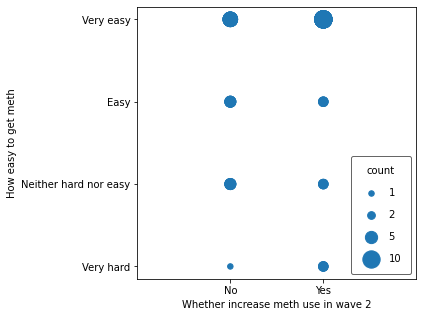

In [10]:
indep_var = df_c1w1['DA1_2']
dep_var = []
for a, b in zip(C1pred_df['ND7'], C1pred_df['Q75']):
    y = 'No' if a <= b else 'Yes'
    # y = a - b
    dep_var.append(y)

dep_var = [x for _, x in sorted(zip(indep_var, dep_var))]

mapping = {1: 'Very hard', 2: 'Hard', 3: 'Neither hard nor easy', 4: 'Easy', 5: 'Very easy', 6: "Don't know"}
indep_var = [f'{mapping[e]}' for e in sorted(indep_var)]

fig = plt.figure(figsize=(5, 5))

# count the occurrences of each point
c = Counter(zip(indep_var,dep_var))
# create a list of the sizes, here multiplied by 10 for scale
s = [30*c[(xx,yy)] for xx,yy in zip(indep_var,dep_var)]

plt.scatter(dep_var, indep_var, s=s)
plt.ylabel('How easy to get meth')
plt.xlabel('Whether increase meth use in wave 2')
plt.xlim(-1, 2)

#make a legend:
pws = [1, 2, 5, 10]
for pw in pws:
    plt.scatter([], [], s=pw*30, c="C0",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, l, labelspacing=1.2, title="count", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", loc='lower right')

plt.show()

#### More on correlations between the below independent variables and the extent of using marijuana and meth across 2 waves

In [4]:
labelings = [
'Years lived in current community',
'How satisfied with living in current community',
'Think whether will still be living in current community 2 years into the future',
'How often felt like belong in community in the past 6 months',
'How often felt out of place in community in the past 6 months',
'Whether there is at least one person to confide in',
'Whether there is someone to receive emotional support from',
'Whether there is someone who would give financial assistance',
'Age',
'Whether regularly smoked cigarettes before',
'How old first time smoked a cigarette',
'Whether smoked cigarettes in the past 6 months',
'How many cigarettes usually smoke in a day',
'Whether vaped or used e-cigarettes with nicotine before',
'How old first time vaped or used e-cigarettes with nicotine',
'Whether vaped or used e-cigarettes with nicotine in the past 6 months',
'How many days vaped or used e-cigarettes with nicotine in the past 30 days',
'Whether regularly used smokeless tobacco before',
'How old first time used smokeless tobacco',
'Whether used smokeless tobacco in the past 6 months',
'How many days used smokeless tobacco in the past 30 days',
'How old first started drinking, including sips',
'How old first started drinking, NOT including sips',
'How old first started drinking to the point of intoxication',
'Whether drank any alcohol in the past 6 months',
'How often drank alcohol in the past 30 days',
'How often had >= 5 (males) or >= 4 (females) alcoholic drinks in one sitting in the past 30 days',
'Whether used a needle to inject a drugs before',
'How old first injected any drug, other than those prescribed',
'How often injected any drug in the past 6 months'] +\
[f'How often injected {d} in the past 6 months' for d in
    ['heroin','opioids','meth','cocaine','heroin and cocaine speedball','heroin and meth speedball','crack cocaine','buprenorphine','something else']] +\
['How often used a new, sterile needle during injection in the past 6 months',
'How often used needles that someone else had already injected with during injection in the past 6 months',
'Whether injected with someone i.e., shared drugs and/or equipment during injection in the past 6 months',
'Whether used a new sterile needle to inject during the last time injected with someone',
'Whether used a needle after anyone else had already injected with it',
'Whether with one person or with more than one person during the last time injected with someone',
'How often used marijuana in the past 6 months',
'How old first used marijuana'] +\
[f'How often used {d} in the past 6 months' for d in
    ['cocaine','Ecstasy/MDMA','PCP/angel dust','amphetamines','meth','barbiturates','benzodiazepines','opiates/opioids','heroin','something else']] +\
[f'How easy to get {d}' for d in ['marijuana','meth','cocaine','heroin','opiods/opiates','benzodiazepines','Ecstasy (MDMA)']] +\
[f'Availability of {d}' for d in ['marijuana','meth','cocaine','heroin','opiods/opiates','benzodiazepines','Ecstasy (MDMA)']] +\
['Whether suffered a drug overdose before',
'Whether suffered a drug overdose in the past 6 months',
'Whether know anyone who has suffered a drug overdose',
'Whether know anyone who has suffered a drug overdose in the past 6 months',
'Whether seen someone overdose on drugs before',
'Whether seen someone overdose on drugs in the past 6 months',
'Whether know anyone who has died from a drug overdose',
'Whether know anyone who has died from a drug overdose in the past 6 months'
] + \
[f'Whether been to {p} program before' for p in ['outpatient','residential','Detox','Methadone/Suboxone treatment','12-step alcohol','12-step drug','other not listed']] + \
[f'Whether currently attending/enrolled in {p} program before' for p in ['outpatient','residential','Detox','Methadone/Suboxone treatment','12-step alcohol','12-step drug','other not listed']] + \
['How often a parent or other adult in the household swore at, insulted, put down, or humiliated them prior to 18th birthday',
'How often a parent or other adult in the household acted in a way that made them afraid that they might be physically hurt prior to 18th birthday',
'How often a parent or other adult in the household pushed, grabbed, slapped, or threw sth at them prior to 18th birthday',
'How often a parent or other adult in the household hit them so hard that they had marks or were injured prior to 18th birthday',
'Whether an adult or person at least 5 years older than them ever touched or fondled them in a sexual way prior to 18th birthday',
'Whether an adult ever had them touch his/her body in a sexual way prior to 18th birthday',
'Whether an adult ever attempted to have oral, anal, or vaginal intercourse with them prior to 18th birthday',
'Whether an adult ever actually had oral, anal, or vaginal intercourse with them prior to 18th birthday',
'How true the following statement prior to 18th birthday: they felt that no one in their family loved them or thought they were important or special',
'How true the following statement prior to 18th birthday: they felt that their family did not look out for each other, feel close to each other, or support each other',
'How true the following statement prior to 18th birthday: they felt that they did not have enough to eat, had to wear dirty clothes, and had no one to protect them',
'How true the following statement prior to 18th birthday: they felt that their parents were too drunk or high to take care of them or take them to the doctor if needed',
'Whether a parent/guardian ever lost to them through divorce, abandonment, or other reason prior to 18th birthday',
'How often their mother or stepmother or female guardian was pushed, grabbed, slapped, or had something thrown at her prior to 18th birthday',
'How often their mother or stepmother or female guardian was kicked, bitten, hit with a fist, or hit with sth hard prior to 18th birthday',
'Whether their mother or stepmother or female guardian was ever repeatedly hit over at least a few minutes or threatened with a gun or knife prior to 18th birthday',
'Whether lived with anyone who was an alcoholic prior to 18th birthday',
'Whether lived with anyone who used street drugs prior to 18th birthday',
'Whether a household member depressed or mentally ill prior to 18th birthday',
'Whether a household member attempted suicide prior to 18th birthday',
'Whether a household member went to prison prior to 18th birthday',
'How often other kids, including siblings threatened, picked on or insulted them prior to 18th birthday',
'How often they felt lonely or rejected prior to 18th birthday',
'Whether lived for 2 or more years in a neighborhood that was dangerous prior to 18th birthday',
'Whether there was a period of 2 or more years their family was very poor prior to 18th birthday',
'How concerned using drugs',
'How concerned buying/selling drugs',
'Whether been incarcerated before',
'Whether been incarcerated in the past 12 months',
'Length of longest incarceration',
'Whether any of incarcerations been drug related',
'Whether received any drug treatment while incarcerated before',
'Current marital status',
'Highest level of education completed',
'Current employment status',
'Religion',
'Which type of Protestant',
'How often attend religious services',
'How much religious beliefs influence daily life in general',
'Whether been homeless before',
'Total household income in last 12 months'
]

In [5]:
cate_mappings = [None,
{1: 'Very dissatisfied', 6: 'Somewhat dissatisfied', 7: 'Neutral', 8: 'Somewhat satisfied', 9: 'Very satisfied'},
{1: 'No', 2: 'Yes'},
{1: 'Never', 2: 'Rarely', 3: 'Sometimes', 4: 'Often', 5: 'Always'},
{1: 'Never', 4: 'Rarely', 5: 'Sometimes', 6: 'Often', 7: 'Always'},
{1: 'No', 2: 'Yes'},
{1: 'No', 3: 'Yes'},
{1: 'No', 3: 'Yes'},
None,
{1: 'No', 2: 'Yes'},
{-1: 'Never smoked', 0: 'Children [0-14]', 1: 'Youth [15-24]', 2: 'Adult [25-64]', 3: 'Senior (>65)'},
{1: 'No', 6: 'Yes'},
{0: 'Never smoked', 1: 'Not at all', 4: 'Less than 1 cigarette a day', 5: '1-5 cigarettes a day', 6: 'Half a pack a day', 7: 'A pack or more a day'},
{1: 'No', 2: 'Yes'},
{-1: 'Never smoked', 0: 'Children [0-14]', 1: 'Youth [15-24]', 2: 'Adult [25-64]', 3: 'Senior (>65)'},
{1: 'No', 2: 'Yes'},
{0: 'Never smoked', 1: '0 days', 2: '1-2 days', 3: '3-9 days', 4: '10-29 days', 5: 'All 30 days'},
{1: 'No', 2: 'Yes'},
{-1: 'Never smoked', 0: 'Children [0-14]', 1: 'Youth [15-24]', 2: 'Adult [25-64]', 3: 'Senior (>65)'},
{1: 'No', 2: 'Yes'},
{0: 'Never smoked', 1: '0 days', 2: '1-2 days', 3: '3-9 days', 4: '10-29 days', 5: 'All 30 days'},
{-2: "Don't know", -1: 'Never drank', 0: 'Children [0-14]', 1: 'Youth [15-24]', 2: 'Adult [25-64]', 3: 'Senior (>65)'},
{-2: "Don't know", -1: 'Never drank', 0: 'Children [0-14]', 1: 'Youth [15-24]', 2: 'Adult [25-64]', 3: 'Senior (>65)'},
{-2: "Don't know", -1: 'Never drank', 0: 'Children [0-14]', 1: 'Youth [15-24]', 2: 'Adult [25-64]', 3: 'Senior (>65)'},
{1: 'No', 2: 'Yes'},
{0: 'Never drank before', 1: 'Never', 9: 'Less than once a month', 10: 'Once a month', 11: '2-3 days per month', 12: 'Once a week', 13: '2-3 days per week', 14: '4-6 days per week', 15: 'Everyday'},
{0: 'Never drank before', 1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: '2-3 days per month', 14: 'Once a week', 15: '2-3 days per week', 16: '4-6 days per week', 17: 'Everyday'},
{1: 'No', 2: 'Yes'},
{-1: 'Never injected', 0: 'Children [0-14]', 1: 'Youth [15-24]', 2: 'Adult [25-64]', 3: 'Senior (>65)'},
{0: 'Never injected', 1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
{0: 'Never injected', 1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
{0: 'Never injected', 1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
{0: 'Never injected', 1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
{0: 'Never injected', 1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
{0: 'Never injected', 1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
{0: 'Never injected', 1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
{0: 'Never injected', 1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
{0: 'Never injected', 1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
{0: 'Never injected', 1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
{-1: 'Never injected', 1: 'Never', 4: 'Rarely', 5: 'About half the time', 6: 'Most of the time', 7: 'Always'},
{-1: 'Never injected', 1: 'Never', 4: 'Rarely', 5: 'About half the time', 6: 'Most of the time', 7: 'Always'},
{-1: 'Never injected', 1: 'No', 2: 'Yes'},
{-1: 'Never injected', 2: 'No', 3: 'Yes'},
{-1: 'Never injected', 1: 'No', 2: 'Yes'},
{-1: 'Never injected', 2: 'One person', 3: 'More than one person'},
{1: 'Never', 9: 'Less than once a month', 10: 'Once a month', 11: 'Once a week', 12: '2-6 times a week', 13: 'One time per day', 14: '2-3 times per day', 15: '4 or more times per day'},
{-1: 'Never used marijuana', 0: 'Children [0-14]', 1: 'Youth [15-24]', 2: 'Adult [25-64]', 3: 'Senior (>65)'},
{1: 'Never', 2: 'Less than once a month', 3: 'Once a month', 4: 'Once a week', 5: '2-6 times a week', 6: 'One time per day', 7: '2-3 times per day', 8: '4 or more times per day'},
{1: 'Never', 2: 'Less than once a month', 3: 'Once a month', 4: 'Once a week', 5: '2-6 times a week', 6: 'One time per day', 7: '2-3 times per day', 8: '4 or more times per day'},
{1: 'Never', 2: 'Less than once a month', 3: 'Once a month', 4: 'Once a week', 5: '2-6 times a week', 6: 'One time per day', 7: '2-3 times per day', 8: '4 or more times per day'},
{1: 'Never', 2: 'Less than once a month', 3: 'Once a month', 4: 'Once a week', 5: '2-6 times a week', 6: 'One time per day', 7: '2-3 times per day', 8: '4 or more times per day'},
{1: 'Never', 2: 'Less than once a month', 3: 'Once a month', 4: 'Once a week', 5: '2-6 times a week', 6: 'One time per day', 7: '2-3 times per day', 8: '4 or more times per day'},
{1: 'Never', 2: 'Less than once a month', 3: 'Once a month', 4: 'Once a week', 5: '2-6 times a week', 6: 'One time per day', 7: '2-3 times per day', 8: '4 or more times per day'},
{1: 'Never', 2: 'Less than once a month', 3: 'Once a month', 4: 'Once a week', 5: '2-6 times a week', 6: 'One time per day', 7: '2-3 times per day', 8: '4 or more times per day'},
{1: 'Never', 2: 'Less than once a month', 3: 'Once a month', 4: 'Once a week', 5: '2-6 times a week', 6: 'One time per day', 7: '2-3 times per day', 8: '4 or more times per day'},
{1: 'Never', 2: 'Less than once a month', 3: 'Once a month', 4: 'Once a week', 5: '2-6 times a week', 6: 'One time per day', 7: '2-3 times per day', 8: '4 or more times per day'},
{1: 'Never', 2: 'Less than once a month', 3: 'Once a month', 4: 'Once a week', 5: '2-6 times a week', 6: 'One time per day', 7: '2-3 times per day', 8: '4 or more times per day'},
{1: 'Very hard', 2: 'Hard', 3: 'Neither hard nor easy', 4: 'Easy', 5: 'Very easy', 6: "Don't know"},
{1: 'Very hard', 2: 'Hard', 3: 'Neither hard nor easy', 4: 'Easy', 5: 'Very easy', 6: "Don't know"},
{1: 'Very hard', 2: 'Hard', 3: 'Neither hard nor easy', 4: 'Easy', 5: 'Very easy', 6: "Don't know"},
{1: 'Very hard', 2: 'Hard', 3: 'Neither hard nor easy', 4: 'Easy', 5: 'Very easy', 6: "Don't know"},
{1: 'Very hard', 2: 'Hard', 3: 'Neither hard nor easy', 4: 'Easy', 5: 'Very easy', 6: "Don't know"},
{1: 'Very hard', 2: 'Hard', 3: 'Neither hard nor easy', 4: 'Easy', 5: 'Very easy', 6: "Don't know"},
{1: 'Very hard', 2: 'Hard', 3: 'Neither hard nor easy', 4: 'Easy', 5: 'Very easy', 6: "Don't know"},
{1: 'Very hard', 2: 'Hard', 3: 'Neither hard nor easy', 4: 'Easy', 5: 'Very easy', 8: "Don't know"},
{1: 'Very hard', 2: 'Hard', 3: 'Neither hard nor easy', 4: 'Easy', 5: 'Very easy', 8: "Don't know"},
{1: 'Very hard', 2: 'Hard', 3: 'Neither hard nor easy', 4: 'Easy', 5: 'Very easy', 8: "Don't know"},
{1: 'Very hard', 2: 'Hard', 3: 'Neither hard nor easy', 4: 'Easy', 5: 'Very easy', 8: "Don't know"},
{1: 'Very hard', 2: 'Hard', 3: 'Neither hard nor easy', 4: 'Easy', 5: 'Very easy', 8: "Don't know"},
{1: 'Very hard', 2: 'Hard', 3: 'Neither hard nor easy', 4: 'Easy', 5: 'Very easy', 8: "Don't know"},
{1: 'Very hard', 2: 'Hard', 3: 'Neither hard nor easy', 4: 'Easy', 5: 'Very easy', 8: "Don't know"},
{1: 'No', 2: 'Yes'},
{0: 'Never suffered drug overdose', 1: 'No', 2: 'Yes'},
{2: 'No', 4: 'Yes'},
{0: "Don't know anyone suffered drug overdose", 1: 'No', 3: 'Yes'},
{0: "Don't know anyone suffered drug overdose", 1: 'No', 2: 'Yes'},
{0: "Don't know anyone suffered drug overdose", 1: 'No', 2: 'Yes'},
{0: "Don't know anyone suffered drug overdose", 1: 'No', 2: 'Yes'},
{0: "Don't know anyone suffered drug overdose", 1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'Never', 3: 'Once or twice', 4: 'Sometimes', 5: 'Often', 6: 'Very often'},
{1: 'Never', 3: 'Once or twice', 4: 'Sometimes', 5: 'Often', 6: 'Very often'},
{1: 'Never', 3: 'Once or twice', 4: 'Sometimes', 5: 'Often', 6: 'Very often'},
{1: 'Never', 3: 'Once or twice', 4: 'Sometimes', 5: 'Often', 6: 'Very often'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{7: 'Never true', 8: 'Rarely true', 9: 'Sometimes true', 10: 'Often true', 11: 'Very often true'},
{1: 'Never true', 7: 'Rarely true', 8: 'Sometimes true', 9: 'Often true', 10: 'Very often true'},
{2: 'Never true', 7: 'Rarely true', 8: 'Sometimes true', 9: 'Often true', 10: 'Very often true'},
{1: 'Never true', 7: 'Rarely true', 8: 'Sometimes true', 9: 'Often true', 10: 'Very often true'},
{1: 'No', 2: 'Yes'},
{1: 'Never', 3: 'Once or twice', 4: 'Sometimes', 5: 'Often', 6: 'Very often'},
{3: 'Never', 4: 'Once or twice', 5: 'Sometimes', 6: 'Often', 7: 'Very often'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'Never', 4: 'Once or twice', 5: 'Sometimes', 6: 'Often', 7: 'Very often'},
{1: 'Never', 4: 'Once or twice', 5: 'Sometimes', 6: 'Often', 7: 'Very often'},
{1: 'No', 2: 'Yes'},
{1: 'No', 2: 'Yes'},
{1: 'Not at all concerned', 2: 'Slightly concerned', 3: 'Somewhat concerned', 4: 'Moderately concerned', 5: 'Extremely concerned'},
{1: 'Not at all concerned', 2: 'Slightly concerned', 3: 'Somewhat concerned', 4: 'Moderately concerned', 5: 'Extremely concerned'},
{1: 'No', 2: 'Yes'},
{-1: 'Never in jail', 1: 'No', 2: 'Yes'},
{-1: 'Never in jail', 1: 'Less than 6 months', 2: 'More than 6 months, less than a year', 3: 'More than a year, less than 2', 4: '2-5 years', 5: '5-10 years', 6: 'More than 10 years'},
{-1: 'Never in jail', 1: 'No', 2: 'Yes'},
{-1: 'Never in jail', 1: 'No', 2: 'Yes'},
{1: 'Married', 2: 'Living together', 3: 'Separated', 4: 'Divorced', 5: 'Widowed', 6: 'Never married'},
{1: 'Less than high school', 2: 'Completed high school or GED', 3: 'Some college', 4: 'Completed 2-year degree', 5: 'Completed 4-year degree', 6: 'Graduate or professional degree'},
{1: 'Employed full-time', 2: 'Employed part-time', 3: 'A homemaker', 4: 'A full-time student', 5: 'Retired', 6: 'Disability - temporary', 7: 'Disability - permanent', 8: 'Unemployed', 9: 'Other'},
{1: 'Protestant', 2: 'Catholic', 3: 'Jewish', 4: 'Muslim', 5: 'No religion', 6: 'Other'},
{-1: 'Non-Protestant', 1: 'Evangelical Protestant', 2: 'Fundamentalists Protestant', 3: 'Mainline Protestant', 4: 'Liberal Protestant', 5: 'Other'},
{1: 'Never', 9: 'Less than once a year', 10: 'About once a year', 11: 'Several times a year', 12: 'About once a month', 13: 'Nearly every week', 14: 'Once a week', 15: 'Several times a week'},
{1: 'N/A, not religious or spiritual', 7: 'Not at all', 8: 'A little', 9: 'Some', 10: 'Quite a bit', 11: 'Very much'},
{1: 'No', 2: 'Yes'},
{1: 'Less than $5k', 12: '$5k-$10k', 13: '$10k-$20k', 14: '$20k-$30k', 15: '$30k-$40k', 16: '$40k-$50k', 17: '$50k-$60k', 18: '$60k-$70k', 19: '$70k-$80k', 20: '$80k-$90k', 21: '$90k-$100k', 22: 'More than $100k'}
]


Marijuana (ND1+Q68)
- DA1_1
- DA2_1
- TX1_1-6
- TX2_1-6
- CJ1-2

In [ ]:
# indep_vars = ['DA1_1','DA2_1'] + [f'TX1_{i}' for i in range(1,7)] + [f'TX2_{i}' for i in range(1,7)] + ['CJ1','CJ2']
indep_vars = list(df_c1w1.drop(columns=['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
            'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df_c1w1.columns) if 'TEXT' in v]).columns)

dep_var_full = []
for a, b in zip(C1pred_df['ND1'], C1pred_df['Q68']):
    if not np.isnan(a) and not np.isnan(b):
        y = 'No' if a <= b else 'Yes'
        # y = a - b
        dep_var_full.append(y)
    else:   dep_var_full.append(np.nan)

for i, v in enumerate(indep_vars):
    indep_var = df_c1w1[v]

    nonan_df = pd.DataFrame({'indep': list(indep_var), 'dep': dep_var_full}).dropna(axis=0)  # remove rows with nan in either column
    indep_var, dep_var = list(nonan_df['indep']), list(nonan_df['dep'])
    
    cate_mapping = cate_mappings[i]
    if cate_mapping is not None:
        dep_var = [x for _, x in sorted(zip(indep_var, dep_var))]
        indep_var = [f'{cate_mapping[e]}' for e in sorted(indep_var)]

    fig = plt.figure(figsize=(5, 5))

    c = Counter(zip(indep_var,dep_var))
    s = [30*c[(xx,yy)] for xx,yy in zip(indep_var,dep_var)]

    plt.scatter(dep_var, indep_var, s=s)  # only plot a point when both x and y non nan
    ytitle = labelings[i]
    if len(ytitle) > 50:     ytitle = '-\n'.join(ytitle[j:j+50] for j in range(0,len(ytitle), 50))  # break line if y title too long
    plt.ylabel(ytitle)
    plt.xlabel('Whether increase marijuana use in wave 2')
    plt.title('Cohort 1: Correlation between variable and marijuana usage across 2 waves')
    plt.xlim(-1, 2)
    #make a legend:
    pws = [1, 2, 5, 10]
    for pw in pws:
        plt.scatter([], [], s=pw*30, c="C0",label=str(pw))

    h, l = plt.gca().get_legend_handles_labels()
    plt.legend(h, l, labelspacing=1.2, title="count", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", loc='lower right')
    plt.savefig(f'plots/analysis/C1-marijuana/C1-marijuana-{v}.pdf', facecolor='white', bbox_inches='tight')


Meth (ND7+Q75)
- DA1_2
- DA2_2
- TX1_1-6
- TX2_1-6
- CJ1-2

In [ ]:
# indep_vars = ['DA1_2','DA2_2'] + [f'TX1_{i}' for i in range(1,7)] + [f'TX2_{i}' for i in range(1,7)] + ['CJ1','CJ2']
indep_vars = list(df_c1w1.drop(columns=['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
            'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df_c1w1.columns) if 'TEXT' in v]).columns)

dep_var_full = []
for a, b in zip(C1pred_df['ND7'], C1pred_df['Q75']):
    if not np.isnan(a) and not np.isnan(b):
        y = 'No' if a <= b else 'Yes'
        # y = a - b
        dep_var_full.append(y)
    else:   dep_var_full.append(np.nan)

for i, v in enumerate(indep_vars):
    indep_var = df_c1w1[v]

    nonan_df = pd.DataFrame({'indep': list(indep_var), 'dep': dep_var_full}).dropna(axis=0)  # remove rows with nan in either column
    indep_var, dep_var = list(nonan_df['indep']), list(nonan_df['dep'])
    
    cate_mapping = cate_mappings[i]
    if cate_mapping is not None:
        dep_var = [x for _, x in sorted(zip(indep_var, dep_var))]
        indep_var = [f'{cate_mapping[e]}' for e in sorted(indep_var)]
    
    fig = plt.figure(figsize=(5, 5))

    c = Counter(zip(indep_var,dep_var))
    s = [30*c[(xx,yy)] for xx,yy in zip(indep_var,dep_var)]

    plt.scatter(dep_var, indep_var, s=s)  # only plot a point when both x and y non nan
    ytitle = labelings[i]
    if len(ytitle) > 50:     ytitle = '-\n'.join(ytitle[j:j+50] for j in range(0,len(ytitle), 50))  # break line if y title too long
    plt.ylabel(ytitle)
    plt.xlabel('Whether increase meth use in wave 2')
    plt.title('Cohort 1: Correlation between variable and meth usage across 2 waves')
    plt.xlim(-1, 2)
    #make a legend:
    pws = [1, 2, 5, 10]
    for pw in pws:
        plt.scatter([], [], s=pw*30, c="C0",label=str(pw))

    h, l = plt.gca().get_legend_handles_labels()
    plt.legend(h, l, labelspacing=1.2, title="count", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", loc='lower right')
    plt.savefig(f'plots/analysis/C1-meth/C1-meth-{v}.pdf', facecolor='white', bbox_inches='tight')

#### Same for Cohort 2

In [11]:
datapath = 'data/original/pre-imputed/'
C2W1nonet_df = pd.read_csv(datapath + 'C2W1_nonnetwork_preimputed.csv')
C2pred_df = pd.read_csv(datapath + 'C2_nonnetwork_pred.csv')

C2W1nonet_vars = list(C2W1nonet_df.columns)

df_c2w1 = impute_MARs(C2W1nonet_vars, C2W1nonet_df)

Marijuana

In [ ]:
# indep_vars = ['DA1_1','DA2_1'] + [f'TX1_{i}' for i in range(1,7)] + [f'TX2_{i}' for i in range(1,7)] + ['CJ1','CJ2']
indep_vars = list(df_c1w1.drop(columns=['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
            'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df_c1w1.columns) if 'TEXT' in v]).columns)

dep_var_full = []
for a, b in zip(C2pred_df['ND1'], C2pred_df['W2_ND1']):
    if not np.isnan(a) and not np.isnan(b):
        y = 'No' if a <= b else 'Yes'
        # y = a - b
        dep_var_full.append(y)
    else:   dep_var_full.append(np.nan)

for i, v in enumerate(indep_vars):
    indep_var = df_c2w1[v]

    nonan_df = pd.DataFrame({'indep': list(indep_var), 'dep': dep_var_full}).dropna(axis=0)  # remove rows with nan in either column
    indep_var, dep_var = list(nonan_df['indep']), list(nonan_df['dep'])
    
    cate_mapping = cate_mappings[i]
    if cate_mapping is not None:
        dep_var = [x for _, x in sorted(zip(indep_var, dep_var))]
        indep_var = [f'{cate_mapping[e]}' for e in sorted(indep_var)]

    fig = plt.figure(figsize=(5, 5))

    c = Counter(zip(indep_var,dep_var))
    s = [20*c[(xx,yy)] for xx,yy in zip(indep_var,dep_var)]

    plt.scatter(dep_var, indep_var, s=s)  # only plot a point when both x and y non nan
    ytitle = labelings[i]
    if len(ytitle) > 50:     ytitle = '-\n'.join(ytitle[j:j+50] for j in range(0,len(ytitle), 50))  # break line if y title too long
    plt.ylabel(ytitle)
    plt.xlabel('Whether increase marijuana use in wave 2')
    plt.title('Cohort 2: Correlation between variable and marijuana usage across 2 waves')
    plt.xlim(-1, 2)
    #make a legend:
    pws = [1, 5, 10, 20]
    for pw in pws:
        plt.scatter([], [], s=pw*20, c="C0",label=str(pw))

    h, l = plt.gca().get_legend_handles_labels()
    plt.legend(h, l, labelspacing=1.2, title="count", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", loc='lower right')
    plt.savefig(f'plots/analysis/C2-marijuana/C2-marijuana-{v}.pdf', facecolor='white', bbox_inches='tight')

Meth

In [ ]:
# indep_vars = ['DA1_2','DA2_2'] + [f'TX1_{i}' for i in range(1,7)] + [f'TX2_{i}' for i in range(1,7)] + ['CJ1','CJ2']
indep_vars = list(df_c1w1.drop(columns=['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
            'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df_c1w1.columns) if 'TEXT' in v]).columns)

dep_var_full = []
for a, b in zip(C2pred_df['ND7'], C2pred_df['W2_ND7']):
    if not np.isnan(a) and not np.isnan(b):
        y = 'No' if a <= b else 'Yes'
        # y = a - b
        dep_var_full.append(y)
    else:   dep_var_full.append(np.nan)

for i, v in enumerate(indep_vars):
    indep_var = df_c2w1[v]

    nonan_df = pd.DataFrame({'indep': list(indep_var), 'dep': dep_var_full}).dropna(axis=0)  # remove rows with nan in either column
    indep_var, dep_var = list(nonan_df['indep']), list(nonan_df['dep'])
    
    cate_mapping = cate_mappings[i]
    if cate_mapping is not None:
        dep_var = [x for _, x in sorted(zip(indep_var, dep_var))]
        indep_var = [f'{cate_mapping[e]}' for e in sorted(indep_var)]

    fig = plt.figure(figsize=(5, 5))

    c = Counter(zip(indep_var,dep_var))
    s = [20*c[(xx,yy)] for xx,yy in zip(indep_var,dep_var)]

    plt.scatter(dep_var, indep_var, s=s)  # only plot a point when both x and y non nan
    ytitle = labelings[i]
    if len(ytitle) > 50:     ytitle = '-\n'.join(ytitle[j:j+50] for j in range(0,len(ytitle), 50))  # break line if y title too long
    plt.ylabel(ytitle)
    plt.xlabel('Whether increase meth use in wave 2')
    plt.title('Cohort 2: Correlation between variable and meth usage across 2 waves')
    plt.xlim(-1, 2)
    #make a legend:
    pws = [1, 5, 10, 20]
    for pw in pws:
        plt.scatter([], [], s=pw*20, c="C0",label=str(pw))

    h, l = plt.gca().get_legend_handles_labels()
    plt.legend(h, l, labelspacing=1.2, title="count", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", loc='lower right')
    plt.savefig(f'plots/analysis/C2-meth/C2-meth-{v}.pdf', facecolor='white', bbox_inches='tight')

### More Systematic Correlation Analysis

Question: whether two categorical variables are dependent or not i.e., find <b>correlation measure </b> between the two

Candidates:
- Chi-squared test --> sensitive to sample size (null hypothesis easier to get rejected for larger sample size)
- Tetrachoric Correlation: correlation between binary categorical variables. [-1, 1], -1 indicates a strong negative correlation, 0 indicates no correlation, and 1 indicates a strong positive correlation
    - Polychoric Correlation: correlation between ordinal categorical variables
- Cramer’s V: correlation between nominal categorical variables. [0, 1], 0 means no association

In [8]:
'''
https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
'''
import scipy.stats as ss

def cramers_V(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    err_flag = True if min( (kcorr-1), (rcorr-1)) == 0 else False  # Debug: division of zero flag
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1))), err_flag

Cramer's V

In [ ]:
for cohort in range(1,3):
    for drug in ['marijuana', 'meth']:

        if cohort == 1:
            df = df_c1w1
            df_pred = C1pred_df
            pred_var = zip(df_pred['ND1'], df_pred['Q68']) if drug == 'marijuana' else zip(df_pred['ND7'], df_pred['Q75'])
        elif cohort == 2:
            df = df_c2w1
            df_pred = C2pred_df
            pred_var = zip(df_pred['ND1'], df_pred['W2_ND1']) if drug == 'marijuana' else zip(df_pred['ND7'], df_pred['W2_ND7'])
        
        indep_vars = list(df.drop(columns=['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
                'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df.columns) if 'TEXT' in v]).columns)
        dep_var = []
        for a, b in pred_var:
            y = 0 if a <= b else 1
            # y = a - b
            dep_var.append(y)

        corrs = []
        corrs_dict = {}
        for v in indep_vars:
            indep_var = df[v]
            corr, err_flag = cramers_V(pd.crosstab(df[v], dep_var).to_numpy())
            if err_flag:    print(f'Division of zero during CramersV calculation at variable {v}, Cohort {str(cohort)}, {drug}')
            corrs.append(corr)
            corrs_dict[v] = corr
        # with open(f'saved-vars/C{cohort}-{drug}-nonnet_CramersV.pkl', 'wb') as file:
        #     pickle.dump(corrs_dict, file)

        fig = plt.figure(figsize=(10, 25))
        plt.barh([v.replace('_', '-') for v in indep_vars], corrs)
        plt.margins(y=0)
        plt.grid(True,axis='x')
        plt.title(f"Cohort {str(cohort)}: Cramer's V correlation between each variable and {drug} usage across 2 waves")
        plt.xlabel("Cramer's V index (in [0, 1], higher is more correlated)")
        plt.savefig(f'plots/analysis/C{str(cohort)}-{drug}/C{str(cohort)}-{drug}_CramersV.pdf', facecolor='white')

In [71]:
pd.crosstab(df_c1w1['DM23'], dep_var)

col_0,0,1
DM23,,
1.0,8,11
12.0,2,2
13.0,1,2
14.0,1,0
15.0,0,1
16.0,1,0
20.0,1,0
21.0,1,0


Chi-square test of independence of variables in a contingency table

Reject null hypothesis (h0: there is no correlation between 2 variables) if p is <= sig_level (usually sig_level = 0.05)

In [ ]:
sig_level = 0.05

for cohort in range(1,3):
    for drug in ['marijuana', 'meth']:

        if cohort == 1:
            df = df_c1w1
            df_pred = C1pred_df
            pred_var = zip(df_pred['ND1'], df_pred['Q68']) if drug == 'marijuana' else zip(df_pred['ND7'], df_pred['Q75'])
        elif cohort == 2:
            df = df_c2w1
            df_pred = C2pred_df
            pred_var = zip(df_pred['ND1'], df_pred['W2_ND1']) if drug == 'marijuana' else zip(df_pred['ND7'], df_pred['W2_ND7'])
        
        indep_vars = list(df.drop(columns=['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
                'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df.columns) if 'TEXT' in v]).columns)
        dep_var = []
        for a, b in pred_var:
            y = 0 if a <= b else 1
            # y = a - b
            dep_var.append(y)

        corrs = []
        corrs_dict = {}
        for v in indep_vars:
            indep_var = df[v]
            chi2, p, dof = chi2_contingency(pd.crosstab(df[v], dep_var).to_numpy())[:3]
            corrs.append(p)
            corrs_dict[v] = p

        fig = plt.figure(figsize=(10, 25))
        plt.barh([v.replace('_', '-') for v in indep_vars], corrs, label=None)
        plt.axvline(x=sig_level, color='r', label=f'significant level: {sig_level}')
        plt.margins(y=0)
        plt.grid(True,axis='x')
        plt.title(f"Cohort {str(cohort)}: Chi-square test's p-value between each variable and {drug} usage across 2 waves")
        plt.xlabel("p-value of the test (lower is more correlated)")
        plt.xlim([0,1])
        plt.legend()
        plt.savefig(f'plots/analysis/C{str(cohort)}-{drug}/C{str(cohort)}-{drug}_chi2test.pdf', facecolor='white')

Combine 2 cohorts into one

In [ ]:
for drug in ['marijuana', 'meth']:

    df = pd.concat([df_c1w1, df_c2w1], ignore_index=True)

    colname_map = {}
    C2pred_keys = list(C2pred_df.columns)
    for i, c in enumerate(list(C1pred_df.columns)):  # map column names of C2pred_df to C1pred_df (since C1W2 has different varnames)
        colname_map[C2pred_keys[i]] = c

    df_pred = pd.concat([C1pred_df, C2pred_df.rename(columns=colname_map)], ignore_index=True)
    pred_var = zip(df_pred['ND1'], df_pred['Q68']) if drug == 'marijuana' else zip(df_pred['ND7'], df_pred['Q75'])
    
    indep_vars = list(df.drop(columns=['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
            'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df.columns) if 'TEXT' in v]).columns)
    dep_var = []
    for a, b in pred_var:
        y = 0 if a <= b else 1
        # y = a - b
        dep_var.append(y)

    corrs = []
    corrs_dict = {}
    for v in indep_vars:
        indep_var = df[v]
        corr, err_flag = cramers_V(pd.crosstab(df[v], dep_var).to_numpy())
        corrs.append(corr)
        corrs_dict[v] = corr

    # with open(f'saved-vars/C12-{drug}-nonnet_CramersV.pkl', 'wb') as file:
    #     pickle.dump(corrs_dict, file)

    fig = plt.figure(figsize=(10, 25))
    plt.barh([v.replace('_', '-') for v in indep_vars], corrs)
    plt.margins(y=0)
    plt.grid(True,axis='x')
    plt.title(f"Cohort 1+2: Cramer's V correlation between each variable and {drug} usage across 2 waves")
    plt.xlabel("Cramer's V index (in [0, 1], higher is more correlated)")
    plt.savefig(f'plots/analysis/C1-{drug}/C12-{drug}_CramersV.pdf', facecolor='white')


In [ ]:
#------------------------------------------------------------------------------------------------------------------------------------------------
sig_level = 0.05
for drug in ['marijuana', 'meth']:

    df = pd.concat([df_c1w1, df_c2w1], ignore_index=True)

    colname_map = {}
    C2pred_keys = list(C2pred_df.columns)
    for i, c in enumerate(list(C1pred_df.columns)):  # map column names of C2pred_df to C1pred_df (since C1W2 has different varnames)
        colname_map[C2pred_keys[i]] = c

    df_pred = pd.concat([C1pred_df, C2pred_df.rename(columns=colname_map)], ignore_index=True)
    pred_var = zip(df_pred['ND1'], df_pred['Q68']) if drug == 'marijuana' else zip(df_pred['ND7'], df_pred['Q75'])
    
    indep_vars = list(df.drop(columns=['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
            'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df.columns) if 'TEXT' in v]).columns)
    dep_var = []
    for a, b in pred_var:
        y = 0 if a <= b else 1
        # y = a - b
        dep_var.append(y)

    corrs = []
    for v in indep_vars:
        indep_var = df[v]
        chi2, p, dof = chi2_contingency(pd.crosstab(df[v], dep_var).to_numpy())[:3]
        corrs.append(p)

    fig = plt.figure(figsize=(10, 25))
    plt.barh([v.replace('_', '-') for v in indep_vars], corrs, label=None)
    plt.axvline(x=sig_level, color='r', label=f'significant level: {sig_level}')
    plt.margins(y=0)
    plt.grid(True,axis='x')
    plt.title(f"Cohort 1+2: Chi-square test's p-value between each variable and {drug} usage across 2 waves")
    plt.xlabel("p-value of the test (lower is more correlated)")
    plt.xlim([0,1])
    plt.legend()
    plt.savefig(f'plots/analysis/C1-{drug}/C12-{drug}_chi2test.pdf', facecolor='white')